# IOB compression of an $n$-disk dataset
This notebook demonstrates autoencoding compression of 32x32 single-channel images with IOB layers. In each image of the $2$-disk dataset, two circular disks of random radius have been placed to create a non-linearly-separable data vector. We here use IOBs to adaptively compress these images using a convolutional neural network and estimate their global intrinsic dimensionality.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
from scipy.stats import chi2
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision

from iobs.simulators import make_n_disk
from iobs.layers import IOBLayer
from iobs.models import BaseAE

/data80/mattho/anaconda3/envs/aeDROP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Device:', device)

Device: cuda


## Generate dataset

In [3]:
# generate images
dim = 32
data = make_n_disk(
    n_samples=10000,
    n_disks=2,
    dim=dim,
    verbose=True
)

100%|██████████| 10000/10000 [00:00<00:00, 23094.80it/s]


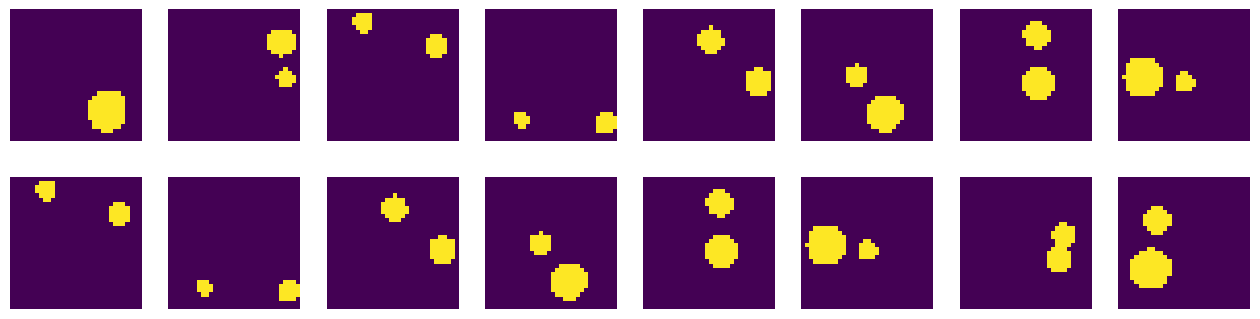

In [4]:
# plot examples
N, M = 2,8
f, axs = plt.subplots(N, M, figsize=(2*M, 2*N))

inds = np.random.choice(len(data), size=N*M, replace=False)
for i in range(N):
    for j in range(M):
        axs[i,j].imshow(data[inds[i*N+j]])
        axs[i,j].axis('off')

In [5]:
# split into training, validation, and testing folds via 80-10-10
nfolds = 10
folds = np.random.choice(nfolds, size=len(data))

in_train = folds < nfolds-2
in_val = folds == nfolds-2
in_test = folds == nfolds-1

In [6]:
# create dataset and dataloaders
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(0.5, 0.5)]
)
itransform = torchvision.transforms.Normalize(-1, 2)
class SimulatedDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx])
        return self.data[idx]

train_dataset = SimulatedDataset(data[in_train], transform=transform)
val_dataset = SimulatedDataset(data[in_val], transform=transform)
test_dataset = SimulatedDataset(data[in_test], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Define encoder-decoder architecture

In [7]:
def build_dense_sequence(shape_list):
    """Convenience function for building a sequence of dense (Linear) layers"""
    layers = []
    for i in range(len(shape_list) - 1):
        layers += [
            nn.Linear(shape_list[i], shape_list[i+1]),
            nn.ReLU()
        ]
    return layers[:-1]  # remove last ReLU

# define a convolutional encoder
encoder = nn.Sequential(
    nn.Conv2d(1, 12, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(12, 24, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(24, 48, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Flatten(),
    *(build_dense_sequence([768, 256, 128, 16])),
).to(device)

# define a convolutional decoder
decoder = nn.Sequential(
    *(build_dense_sequence([16, 128, 256, 768])),
    nn.Unflatten(dim=1,
                 unflattened_size=(48, 4, 4)),
    nn.ConvTranspose2d(48, 24, 4,
                       stride=2, padding=1),
    nn.ReLU(True),
    nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.ConvTranspose2d(12, 1, 4, stride=2, padding=1),
).to(device)

# define a IOB with a max width of 16 features
bottleneck = IOBLayer(16, device=device)

In [8]:
# build a simple autoencoder model
model = BaseAE(
    encoder=encoder,
    decoder=decoder,
    bottleneck=bottleneck
)

In [9]:
# define a criterion for log-likelihood maximization
criterion = nn.MSELoss()

def lossfn(model, batch_features):
    """Loss function for averaging loss over all bottleneck widths evenly"""
    outputs = model.forward_all(batch_features)
    target = batch_features.unsqueeze(1).expand(*(outputs.shape))
    loss = criterion(outputs, target)
    return loss

## Train

In [10]:
# Set hyperparameters

# training
max_epochs = 3000
lr = 5e-5
print_every = 10

# early stopping
min_change = 0.0001
patience = 20

optimizer = optim.Adam(model.parameters(), lr)

In [11]:
trloss_rec = []
valoss_rec = []
wait = 0
min_valoss = np.inf
for epoch in range(max_epochs):
    # train
    trloss = 0
    for batch_features in train_loader:
        batch_features = batch_features.float().to(device)
        optimizer.zero_grad()
        batch_loss = lossfn(model, batch_features)
        batch_loss.backward()
        optimizer.step()
        trloss += batch_loss.item()
    trloss = trloss / len(train_loader)

    # test
    with torch.no_grad():
        valoss = 0
        for batch_features in val_loader:
            batch_features = batch_features.float().to(device)
            batch_loss = lossfn(model, batch_features)
            valoss += batch_loss.item()
        valoss = valoss / len(val_loader)

    # record loss
    trloss_rec.append(trloss)
    valoss_rec.append(valoss)
    if epoch % print_every == 0:
        print(f"epoch : {epoch + 1}/{max_epochs}, "
              f"loss = {trloss:.6f}, val loss = {valoss:.6f}")
    
    # compute early stopping
    if valoss < min_valoss*(1-min_change):
        wait = 0
        min_valoss = valoss
    else:
        wait += 1
    if wait >= patience:
        print(f'Early stopping at epoch {epoch + 1}/{max_epochs}')
        break

epoch : 1/3000, loss = 1.112633, val loss = 0.579256
epoch : 11/3000, loss = 0.261754, val loss = 0.252329
epoch : 21/3000, loss = 0.205279, val loss = 0.203929
epoch : 31/3000, loss = 0.168834, val loss = 0.167960
epoch : 41/3000, loss = 0.151977, val loss = 0.151744
epoch : 51/3000, loss = 0.141673, val loss = 0.141657
epoch : 61/3000, loss = 0.135141, val loss = 0.135249
epoch : 71/3000, loss = 0.130417, val loss = 0.130909
epoch : 81/3000, loss = 0.126923, val loss = 0.127477
epoch : 91/3000, loss = 0.124235, val loss = 0.124853
epoch : 101/3000, loss = 0.121889, val loss = 0.122603
epoch : 111/3000, loss = 0.119928, val loss = 0.120748
epoch : 121/3000, loss = 0.118298, val loss = 0.119557
epoch : 131/3000, loss = 0.116943, val loss = 0.118420
epoch : 141/3000, loss = 0.115735, val loss = 0.117110
epoch : 151/3000, loss = 0.114728, val loss = 0.116136
epoch : 161/3000, loss = 0.113847, val loss = 0.115406
epoch : 171/3000, loss = 0.113060, val loss = 0.114592
epoch : 181/3000, los

Text(0.5, 0, 'Epoch')

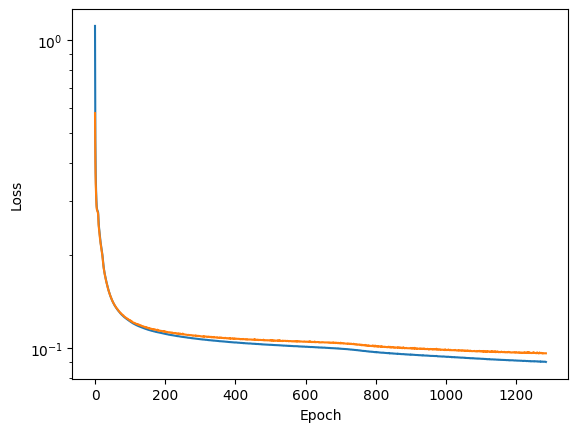

In [17]:
# plot loss vs. time
lenrec = len(trloss_rec)

f, ax = plt.subplots()
ax.semilogy()
ax.plot(range(lenrec), trloss_rec, label='train')
ax.plot(range(lenrec), valoss_rec, label='validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

## Test

In [18]:
# embed and reconstruct all test images, for all possible bottleneck widths
test_data = test_dataset.data
recon_data = np.zeros_like(test_data)
recon_data = np.repeat(recon_data[:,None,...], repeats=model.latent_dim+1, axis=1)
with torch.no_grad():
    i = 0
    for j, batch_features in enumerate(test_loader):
        batch_features = batch_features.float().to(device)
        recon_data[i:i+len(batch_features)] = \
            itransform(model.forward_all(batch_features).detach().cpu()[:,:,0,...,None])
        i += len(batch_features)

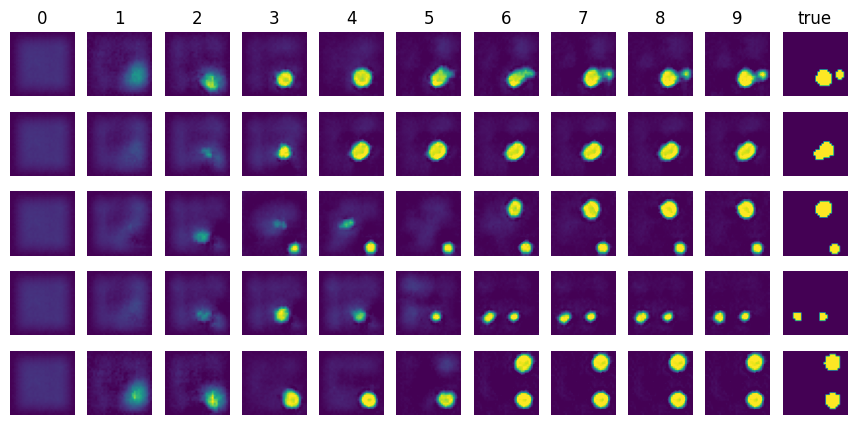

In [19]:
# show reconstruction examples, as a function of bottleneck width
N = 5
max_n_open = 9

f, axs = plt.subplots(N, max_n_open+2, figsize=(max_n_open*1.2, N))
inds = np.random.choice(len(test_data), size=N, replace=False)
for i in range(N):
    for j in range(max_n_open+1):
        axs[i,j].imshow(recon_data[inds[i], j], vmin=0, vmax=1)
        axs[i,j].axis('off')   
    
    axs[i,-1].imshow(test_data[inds[i]], vmin=0, vmax=1)
    axs[i,-1].axis('off')
        
axs[0,-1].set_title('true')
for j in range(max_n_open+1):
    axs[0,j].set_title(j)

Text(0, 0.5, '$\\mathrm{MSE}/\\sigma^2_\\mathrm{pop}$')

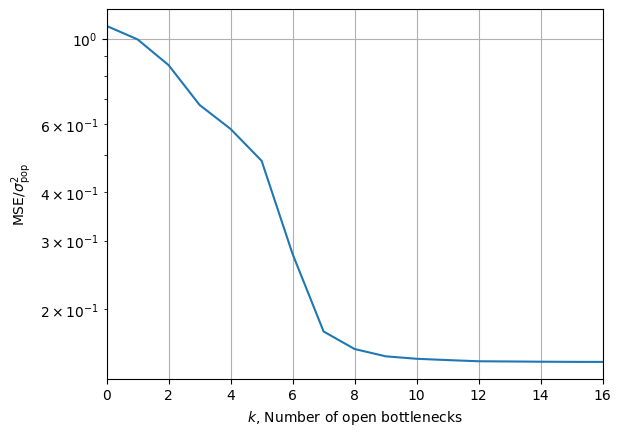

In [20]:
# calculate and plot the % variance explained, as a function of bottlneeck width
testvar = np.sum(np.var(test_data, axis=0).shape)
test_percerr = np.sum(np.mean((recon_data-test_data[:,None])**2, axis=0), axis=(1,2,3))/testvar

f,ax = plt.subplots()
ax.semilogy()
ax.plot(test_percerr)
ax.grid()
ax.set_xlim(0, model.latent_dim)
ax.set_xlabel('$k$, Number of open bottlenecks')
ax.set_ylabel('$\mathrm{MSE}/\sigma^2_\mathrm{pop}$')

## Calculate intrinsic dimensionality

In [21]:
# calculate intrinisic dimensionality

p = 0.05  # p-value at which to reject the null hypothesis
diff_loglik = -np.diff(test_percerr/2)*len(test_data)
intdim = np.argwhere(diff_loglik<chi2.isf(p,1))[0,0]
print(f'Intrinsic Dimensionality: {intdim}')

Intrinsic Dimensionality: 8
